In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd
import pandas_datareader.data as web
import pickle 
import requests
import tensorflow as tf

C:\Users\kenneth\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\kenneth\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\kenneth\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\kenneth\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\f

In [14]:
image_path = 'D:\kenneth\agent\images'
ticker = '^GSPC'
start=('2019-01-01')
end=('2019-12-31')
df=web.DataReader(ticker,'yahoo',start,end)
df.to_csv(ticker+'.csv')
df = pd.read_csv('D:/kenneth/agent/'+ticker+'.csv', index_col=0, parse_dates=True)

## Double Recurrent Q-learning agent

In [3]:
from collections import deque
import random

name = 'Double Recurrent Q-learning agent'


class Model:
    def __init__(self, input_size, output_size, layer_size, learning_rate, name):
        with tf.variable_scope(name):
            self.X = tf.placeholder(tf.float32, (None, None, input_size))
            self.Y = tf.placeholder(tf.float32, (None, output_size))
            cell = tf.nn.rnn_cell.LSTMCell(layer_size, state_is_tuple = False)
            self.hidden_layer = tf.placeholder(tf.float32, (None, 2 * layer_size))
            self.rnn,self.last_state = tf.nn.dynamic_rnn(inputs=self.X,cell=cell,
                                                    dtype=tf.float32,
                                                    initial_state=self.hidden_layer)
            self.logits = tf.layers.dense(self.rnn[:,-1], output_size)
            self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
            self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 256
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.INITIAL_FEATURES = np.zeros((4, self.state_size))
        self.model = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE,
                           'real_model')
        self.model_negative = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE,
                                   'negative_model')
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        self.trainable = tf.trainable_variables()
    
    def _assign(self, from_name, to_name):
        from_w = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=from_name)
        to_w = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=to_name)
        for i in range(len(from_w)):
            assign_op = to_w[i].assign(from_w[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, dead, rnn_state):
        self.MEMORIES.append((state, action, reward, new_state, dead, rnn_state))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        init_values = np.array([a[-1] for a in replay])
        Q = self.sess.run(self.model.logits, feed_dict={self.model.X:states, 
                                                   self.model.hidden_layer:init_values})
        Q_new = self.sess.run(self.model.logits, feed_dict={self.model.X:new_states, 
                                                       self.model.hidden_layer:init_values})
        Q_new_negative = self.sess.run(self.model_negative.logits, 
                                  feed_dict={self.model_negative.X:new_states, 
                                             self.model_negative.hidden_layer:init_values})
        replay_size = len(replay)
        X = np.empty((replay_size, 4, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        INIT_VAL = np.empty((replay_size, 2 * self.LAYER_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, dead_r, rnn_memory = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not dead_r:
                target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
            X[i] = state_r
            Y[i] = target
            INIT_VAL[i] = rnn_memory
        return X, Y, INIT_VAL
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        init_value = np.zeros((1, 2 * self.LAYER_SIZE))
        for k in range(self.INITIAL_FEATURES.shape[0]):
            self.INITIAL_FEATURES[k,:] = state
        for t in range(0, len(self.trend) - 1, self.skip):
            action, last_state = self.sess.run([self.model.logits,self.model.last_state],
                                                feed_dict={self.model.X:[self.INITIAL_FEATURES],
                                                            self.model.hidden_layer:init_value})
            action, init_value = np.argmax(action[0]), last_state
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
            self.INITIAL_FEATURES = new_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
            
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            init_value = np.zeros((1, 2 * self.LAYER_SIZE))
            for k in range(self.INITIAL_FEATURES.shape[0]):
                self.INITIAL_FEATURES[k,:] = state
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign('real_model', 'negative_model')
                
                if np.random.rand() < self.EPSILON:
                    action = np.random.randint(self.OUTPUT_SIZE)
                else:
                    action, last_state = self.sess.run([self.model.logits,
                                                  self.model.last_state],
                                                  feed_dict={self.model.X:[self.INITIAL_FEATURES],
                                                             self.model.hidden_layer:init_value})
                    action, init_value = np.argmax(action[0]), last_state
                    
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
                
                self._memorize(self.INITIAL_FEATURES, action, invest, new_state, 
                               starting_money < initial_money, init_value[0])
                self.INITIAL_FEATURES = new_state
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                X, Y, INIT_VAL = self._construct_memories(replay)
                
                cost, _ = self.sess.run([self.model.cost, self.model.optimizer], 
                                        feed_dict={self.model.X: X, self.model.Y:Y,
                                                  self.model.hidden_layer: INIT_VAL})
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 768.791260.3, cost: 0.333480, total money: 10768.791260
epoch: 20, total rewards: 724.070312.3, cost: 0.217013, total money: 10724.070312
epoch: 30, total rewards: 483.862061.3, cost: 0.293139, total money: 4481.152100
epoch: 40, total rewards: 1115.289795.3, cost: 0.914696, total money: 11115.289795
epoch: 50, total rewards: -35.029785.3, cost: 0.217404, total money: 943.440186
epoch: 60, total rewards: 270.239746.3, cost: 0.796127, total money: 1263.009766
epoch: 70, total rewards: 366.501465.3, cost: 0.275293, total money: 4384.311523
epoch: 80, total rewards: 816.188965.3, cost: 0.426617, total money: 10816.188965
epoch: 90, total rewards: 523.970703.3, cost: 0.248904, total money: 7527.980713
epoch: 100, total rewards: 679.309082.3, cost: 1.084521, total money: 7674.789062
epoch: 110, total rewards: -101.399658.3, cost: 0.678311, total money: 9898.600342
epoch: 120, total rewards: 994.130859.3, cost: 0.674724, total money: 7983.840820
epoch: 130, total re

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 12: buy 1 unit at price 2670.709961, total balance 7329.290039
day 13, sell 1 unit at price 2632.899902, investment -1.415731 %, total balance 9962.189941,
day 15: buy 1 unit at price 2642.330078, total balance 7319.859863
day 16: buy 1 unit at price 2664.760010, total balance 4655.099854
day 17, sell 1 unit at price 2643.850098, investment 0.057526 %, total balance 7298.949951,
day 18, sell 1 unit at price 2640.000000, investment -0.929165 %, total balance 9938.949951,
day 22: buy 1 unit at price 2724.870117, total balance 7214.079834
day 24, sell 1 unit at price 2731.610107, investment 0.247351 %, total balance 9945.689941,
day 27: buy 1 unit at price 2709.800049, total balance 7235.889893
day 31, sell 1 unit at price 2775.600098, investment 2.428225 %, total balance 10011.489990,
day 42: buy 1 unit at price 2789.649902, total balance 7221.840088
day 43, sell 1 unit at price 2771.449951, investment -0.652410 %, total balance 9993.290039,
day 44: buy 1 unit at price 2748.929932, t

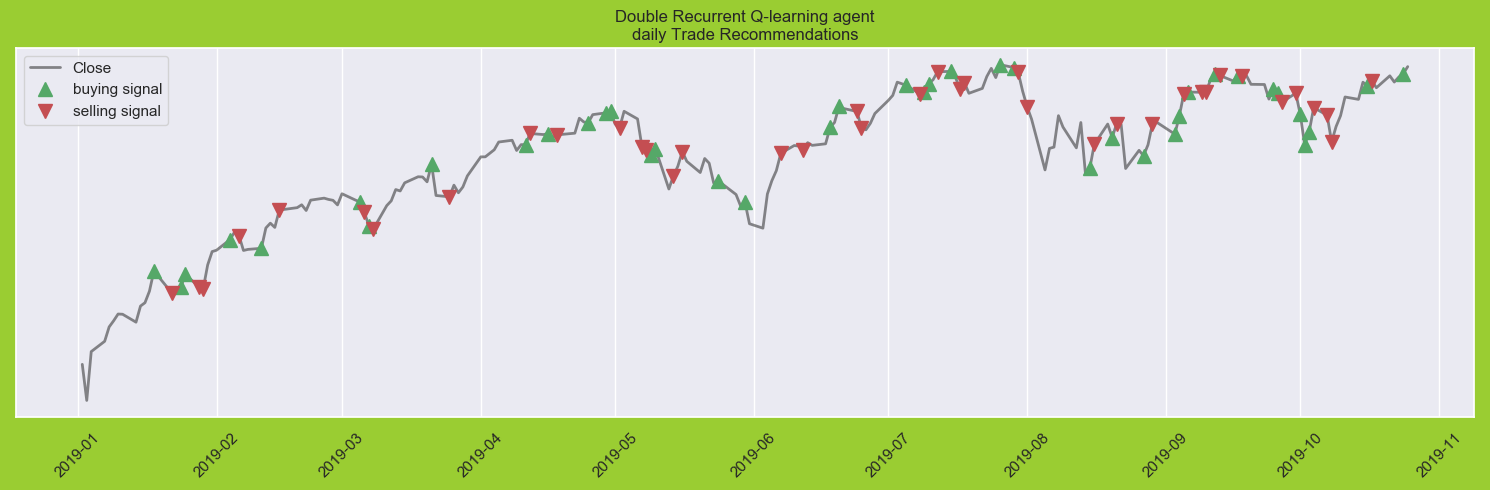

In [15]:
close = df['Close']
fig = plt.figure(figsize = (15,5), facecolor='yellowgreen', dpi=100)
plt.plot(close, color='k', lw=2., alpha=0.5)
plt.plot(close, '^', markersize=10, color='g', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='r', label = 'selling signal', markevery = states_sell)
plt.title(name+'\n'+'daily Trade Recommendations')
plt.legend()
plt.xticks(rotation=45)
plt.gca().axes.get_yaxis().set_visible(False)
fig.tight_layout()
plt.savefig('images/'+ticker+name+'.png', facecolor='yellowgreen', dpi=100)
plt.show()

In [7]:
display_days = 30
total_days= df.shape[0]
display_from = total_days-display_days

In [8]:
new_buy = []
for i in(states_buy):
    if i > display_from:
        adj = i- display_from
        new_buy.append(adj)
new_buy

[1, 7, 8, 11, 12, 13, 22, 28]

In [9]:
new_sell = []
for i in(states_sell):
    if i > display_from:
        adj = i- display_from
        new_sell.append(adj)
new_sell

[2, 9, 10, 14, 15, 16, 23]

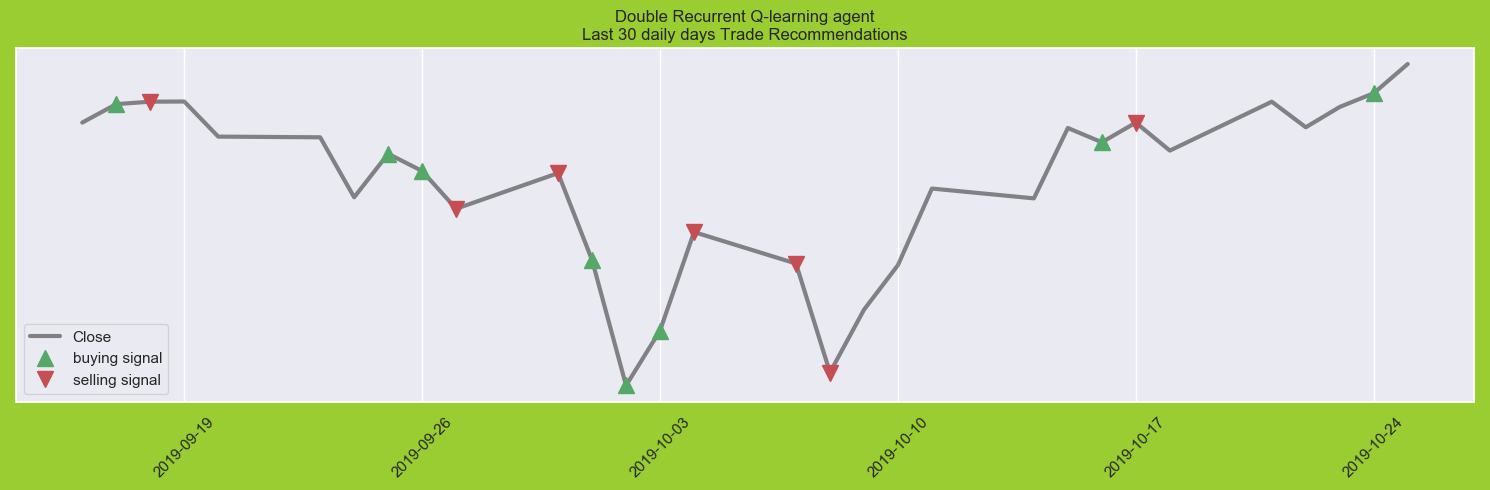

In [16]:
close = df['Close'][-display_days:]
fig = plt.figure(figsize = (15,5), facecolor='yellowgreen', dpi=100)
plt.plot(close, color='k', lw=3., alpha=0.5)
plt.plot(close, '^', markersize=12, color='g',alpha=1.0,label = 'buying signal', markevery = new_buy)
plt.plot(close, 'v', markersize=12, color='r',alpha=1.0, label = 'selling signal', markevery = new_sell)
plt.title(name+'\n'+'Last '+str(display_days)+' daily days Trade Recommendations')
plt.legend()
plt.xticks(rotation=45)
plt.gca().axes.get_yaxis().set_visible(False)
fig.tight_layout()
#plt.savefig('images/'+ticker+name+'.png', facecolor='yellowgreen', dpi=100)
plt.show()